In [41]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path

## Download train and test data

In [42]:
train_data = datasets.FashionMNIST(root='FashionMNIST_data',
                                   train=True,
                                   transform=ToTensor(),
                                   target_transform=None,
                                   download=True)

test_data = datasets.FashionMNIST(root='FashionMNIST_data',
                                  train=False,
                                  transform=ToTensor(),
                                  target_transform=None,
                                  download=True)

In [43]:
print(f"Length of train data : {len(train_data)}")
print(f"Length of test data : {len(test_data)}")

Length of train data : 60000
Length of test data : 10000


In [44]:
label_class = train_data.class_to_idx
label_class

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

## Train and Test dataloader

In [45]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=True)

In [46]:
train_dataloader.batch_size

32

In [47]:
len(train_dataloader)

1875

In [48]:
train_dataloader

In [49]:
next(iter(train_dataloader))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

## visualize data

(-0.5, 27.5, 27.5, -0.5)

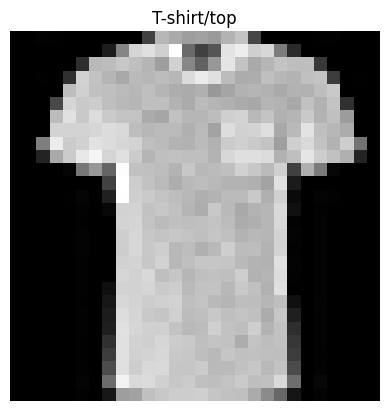

In [50]:
train_feature_batch, train_label_batch = next(iter(train_dataloader))
random_idx = torch.randint(low=0, high=len(train_feature_batch), size=[1]).item()
img, lbl = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(list(label_class.keys())[lbl])
plt.axis(False)

## Build model

In [51]:
class FashionMNISTModel(nn.Module):
    def __init__(self,
                 in_features :int,
                 hidden_units :int,
                 out_features :int):
        super().__init__()
        self.conv_stack_1 = nn.Sequential(nn.Conv2d(in_channels=in_features,
                                          out_channels=hidden_units,
                                          kernel_size=3,
                                          padding=1,
                                          stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                          out_channels=hidden_units,
                                          kernel_size=3,
                                          padding=1,
                                          stride=1),
                                          nn.MaxPool2d(kernel_size=2))
        
        self.conv_stack_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=1,
                                                    stride=1),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units,
                                                    out_channels=hidden_units,
                                                    kernel_size=3,
                                                    padding=1,
                                                    stride=1),
                                          nn.MaxPool2d(kernel_size=2))
                            
        self.linear_stack = nn.Sequential(nn.Flatten(),
                                          nn.Linear(in_features=hidden_units*7*7, out_features=out_features))

    def forward(self, X :torch.Tensor):
        #print(X.shape)
        X = self.conv_stack_1(X)
        #print(X.shape)
        X = self.conv_stack_2(X)
        #print(X.shape)
        X = self.linear_stack(X)
        #print(X.shape)
        return X

In [52]:
model = FashionMNISTModel(in_features=1,
                          hidden_units=10,
                          out_features=10)
                          
model

FashionMNISTModel(
  (conv_stack_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_stack_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Train/Test function

In [53]:
torch.manual_seed(42)

def train_model(model :torch.nn.Module,
                train_dataloader :DataLoader,
                loss_fn :nn.functional,
                acc_fn :nn.functional,
                optimizer :torch.optim):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in train_dataloader:
        train_logits = model(X)
        train_loss += loss_fn(train_logits, y)
        train_pred = torch.softmax(train_logits, dim=1).argmax(dim=1)
        train_acc += acc_fn(train_pred, y)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    return train_loss, train_acc*100


def eval_model(model :nn.Module,
               test_dataloader :DataLoader,
               loss_fn :nn.functional,
               acc_fn :nn.functional):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        test_acc = 0
        for X,y in test_dataloader:
            test_logits = model(X)
            test_loss += loss_fn(test_logits, y)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_acc += acc_fn(test_pred, y)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        return test_loss, test_acc*100

## Train/Test loop

In [61]:
torch.manual_seed(42)

# define accuracy function
acc_fn = Accuracy(task='multiclass',
                  num_classes=10)

# define loss function
loss_fn = nn.CrossEntropyLoss()

# define optimizer
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.05)

epochs = 50
epoch_values = []
train_loss_values = []
test_loss_values = []

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_model(model,
                                        train_dataloader,
                                        loss_fn,
                                        acc_fn,
                                        optimizer)
    
    test_loss, test_acc = eval_model(model,
                                     test_dataloader,
                                     loss_fn,
                                     acc_fn)
    if epoch%1==0:
        print(f"Epoch : {epoch} | Train_loss : {train_loss :.3f} | Train_acc : {train_acc :.2f}% | Test_loss : {test_loss :.3f} | test_acc : {test_acc :.2f}%")
        epoch_values.append(epoch)
        train_loss_values.append(train_loss)
        test_loss_values.append(test_loss)

  2%|▏         | 1/50 [00:31<26:07, 31.99s/it]

Epoch : 0 | Train_loss : 1.142 | Train_acc : 64.43% | Test_loss : 1.077 | test_acc : 64.43%


  4%|▍         | 2/50 [01:02<25:07, 31.41s/it]

Epoch : 1 | Train_loss : 1.072 | Train_acc : 65.24% | Test_loss : 1.024 | test_acc : 65.15%


  6%|▌         | 3/50 [01:33<24:27, 31.22s/it]

Epoch : 2 | Train_loss : 1.018 | Train_acc : 65.98% | Test_loss : 0.982 | test_acc : 66.23%


  8%|▊         | 4/50 [02:04<23:46, 31.01s/it]

Epoch : 3 | Train_loss : 0.976 | Train_acc : 66.92% | Test_loss : 0.956 | test_acc : 65.61%


 10%|█         | 5/50 [02:35<23:12, 30.93s/it]

Epoch : 4 | Train_loss : 0.950 | Train_acc : 66.36% | Test_loss : 1.035 | test_acc : 64.94%


 12%|█▏        | 6/50 [03:07<22:51, 31.16s/it]

Epoch : 5 | Train_loss : 1.030 | Train_acc : 65.04% | Test_loss : 1.706 | test_acc : 63.42%


 14%|█▍        | 7/50 [03:37<22:14, 31.04s/it]

Epoch : 6 | Train_loss : 1.689 | Train_acc : 63.58% | Test_loss : 1.580 | test_acc : 44.83%


 16%|█▌        | 8/50 [04:08<21:40, 30.97s/it]

Epoch : 7 | Train_loss : 1.583 | Train_acc : 45.17% | Test_loss : 1.197 | test_acc : 63.74%


 18%|█▊        | 9/50 [04:42<21:41, 31.75s/it]

Epoch : 8 | Train_loss : 1.195 | Train_acc : 63.97% | Test_loss : 1.060 | test_acc : 65.30%


 20%|██        | 10/50 [05:13<21:02, 31.56s/it]

Epoch : 9 | Train_loss : 1.058 | Train_acc : 65.19% | Test_loss : 0.957 | test_acc : 66.85%


 22%|██▏       | 11/50 [05:44<20:21, 31.32s/it]

Epoch : 10 | Train_loss : 0.951 | Train_acc : 67.10% | Test_loss : 0.918 | test_acc : 67.57%


 24%|██▍       | 12/50 [06:15<19:47, 31.24s/it]

Epoch : 11 | Train_loss : 0.911 | Train_acc : 68.26% | Test_loss : 0.898 | test_acc : 67.40%


 26%|██▌       | 13/50 [06:45<19:08, 31.04s/it]

Epoch : 12 | Train_loss : 0.890 | Train_acc : 67.75% | Test_loss : 0.912 | test_acc : 66.29%


 28%|██▊       | 14/50 [07:16<18:36, 31.00s/it]

Epoch : 13 | Train_loss : 0.902 | Train_acc : 66.51% | Test_loss : 1.053 | test_acc : 65.50%


 30%|███       | 15/50 [07:47<18:01, 30.90s/it]

Epoch : 14 | Train_loss : 1.045 | Train_acc : 65.96% | Test_loss : 1.134 | test_acc : 66.04%


 32%|███▏      | 16/50 [08:17<17:25, 30.74s/it]

Epoch : 15 | Train_loss : 1.125 | Train_acc : 66.15% | Test_loss : 1.050 | test_acc : 65.41%


 34%|███▍      | 17/50 [08:46<16:37, 30.23s/it]

Epoch : 16 | Train_loss : 1.042 | Train_acc : 66.15% | Test_loss : 0.920 | test_acc : 68.96%


 36%|███▌      | 18/50 [09:16<16:04, 30.14s/it]

Epoch : 17 | Train_loss : 0.913 | Train_acc : 69.51% | Test_loss : 0.858 | test_acc : 70.07%


 38%|███▊      | 19/50 [09:46<15:27, 29.91s/it]

Epoch : 18 | Train_loss : 0.849 | Train_acc : 70.56% | Test_loss : 0.845 | test_acc : 69.68%


 40%|████      | 20/50 [10:15<14:49, 29.64s/it]

Epoch : 19 | Train_loss : 0.834 | Train_acc : 70.25% | Test_loss : 0.845 | test_acc : 68.83%


 42%|████▏     | 21/50 [10:44<14:14, 29.47s/it]

Epoch : 20 | Train_loss : 0.833 | Train_acc : 69.59% | Test_loss : 0.900 | test_acc : 68.27%


 44%|████▍     | 22/50 [11:13<13:43, 29.41s/it]

Epoch : 21 | Train_loss : 0.888 | Train_acc : 68.46% | Test_loss : 1.037 | test_acc : 67.16%


 46%|████▌     | 23/50 [27:07<2:18:05, 306.87s/it]

Epoch : 22 | Train_loss : 1.027 | Train_acc : 67.92% | Test_loss : 0.955 | test_acc : 67.08%


 48%|████▊     | 24/50 [27:38<1:37:06, 224.09s/it]

Epoch : 23 | Train_loss : 0.947 | Train_acc : 67.16% | Test_loss : 0.957 | test_acc : 67.20%


 50%|█████     | 25/50 [35:51<2:06:58, 304.74s/it]

Epoch : 24 | Train_loss : 0.948 | Train_acc : 67.72% | Test_loss : 0.896 | test_acc : 67.61%


 52%|█████▏    | 26/50 [51:57<3:21:20, 503.34s/it]

Epoch : 25 | Train_loss : 0.884 | Train_acc : 67.79% | Test_loss : 0.876 | test_acc : 67.87%


 54%|█████▍    | 27/50 [52:27<2:18:28, 361.22s/it]

Epoch : 26 | Train_loss : 0.866 | Train_acc : 68.07% | Test_loss : 0.891 | test_acc : 67.72%


 56%|█████▌    | 28/50 [1:00:59<2:28:59, 406.35s/it]

Epoch : 27 | Train_loss : 0.878 | Train_acc : 68.00% | Test_loss : 0.907 | test_acc : 67.76%


 58%|█████▊    | 29/50 [1:01:28<1:42:40, 293.37s/it]

Epoch : 28 | Train_loss : 0.896 | Train_acc : 68.06% | Test_loss : 0.888 | test_acc : 67.93%


 60%|██████    | 30/50 [1:01:58<1:11:21, 214.09s/it]

Epoch : 29 | Train_loss : 0.874 | Train_acc : 68.17% | Test_loss : 0.862 | test_acc : 68.24%


 62%|██████▏   | 31/50 [1:02:27<50:13, 158.61s/it]  

Epoch : 30 | Train_loss : 0.852 | Train_acc : 68.38% | Test_loss : 0.872 | test_acc : 68.16%


 64%|██████▍   | 32/50 [1:02:57<35:59, 119.98s/it]

Epoch : 31 | Train_loss : 0.857 | Train_acc : 68.41% | Test_loss : 0.865 | test_acc : 68.23%


 66%|██████▌   | 33/50 [1:03:29<26:34, 93.80s/it] 

Epoch : 32 | Train_loss : 0.854 | Train_acc : 68.48% | Test_loss : 0.876 | test_acc : 68.39%


 68%|██████▊   | 34/50 [1:04:00<19:56, 74.79s/it]

Epoch : 33 | Train_loss : 0.860 | Train_acc : 68.57% | Test_loss : 0.847 | test_acc : 68.47%


 70%|███████   | 35/50 [1:04:29<15:17, 61.16s/it]

Epoch : 34 | Train_loss : 0.835 | Train_acc : 68.79% | Test_loss : 0.861 | test_acc : 68.66%


 72%|███████▏  | 36/50 [1:04:59<12:03, 51.67s/it]

Epoch : 35 | Train_loss : 0.845 | Train_acc : 68.76% | Test_loss : 0.837 | test_acc : 68.73%


 74%|███████▍  | 37/50 [1:05:29<09:49, 45.31s/it]

Epoch : 36 | Train_loss : 0.825 | Train_acc : 69.06% | Test_loss : 0.859 | test_acc : 68.80%


 76%|███████▌  | 38/50 [1:05:59<08:06, 40.56s/it]

Epoch : 37 | Train_loss : 0.842 | Train_acc : 68.94% | Test_loss : 0.827 | test_acc : 69.13%


 78%|███████▊  | 39/50 [1:06:28<06:48, 37.16s/it]

Epoch : 38 | Train_loss : 0.814 | Train_acc : 69.32% | Test_loss : 0.850 | test_acc : 68.97%


 80%|████████  | 40/50 [1:06:57<05:48, 34.88s/it]

Epoch : 39 | Train_loss : 0.832 | Train_acc : 69.13% | Test_loss : 0.817 | test_acc : 69.48%


 82%|████████▏ | 41/50 [1:07:27<04:59, 33.29s/it]

Epoch : 40 | Train_loss : 0.804 | Train_acc : 69.64% | Test_loss : 0.843 | test_acc : 69.07%


 84%|████████▍ | 42/50 [1:07:56<04:16, 32.02s/it]

Epoch : 41 | Train_loss : 0.824 | Train_acc : 69.32% | Test_loss : 0.810 | test_acc : 69.71%


 86%|████████▌ | 43/50 [1:08:26<03:38, 31.27s/it]

Epoch : 42 | Train_loss : 0.796 | Train_acc : 69.98% | Test_loss : 0.835 | test_acc : 69.24%


 88%|████████▊ | 44/50 [1:08:56<03:06, 31.01s/it]

Epoch : 43 | Train_loss : 0.817 | Train_acc : 69.52% | Test_loss : 0.801 | test_acc : 69.98%


 90%|█████████ | 45/50 [1:09:25<02:32, 30.54s/it]

Epoch : 44 | Train_loss : 0.787 | Train_acc : 70.36% | Test_loss : 0.828 | test_acc : 69.53%


 92%|█████████▏| 46/50 [1:09:55<02:00, 30.18s/it]

Epoch : 45 | Train_loss : 0.809 | Train_acc : 69.68% | Test_loss : 0.794 | test_acc : 70.21%


 94%|█████████▍| 47/50 [1:10:24<01:29, 29.92s/it]

Epoch : 46 | Train_loss : 0.780 | Train_acc : 70.73% | Test_loss : 0.821 | test_acc : 69.64%


 96%|█████████▌| 48/50 [1:10:54<00:59, 29.95s/it]

Epoch : 47 | Train_loss : 0.801 | Train_acc : 69.90% | Test_loss : 0.788 | test_acc : 70.55%


 98%|█████████▊| 49/50 [1:11:24<00:29, 29.85s/it]

Epoch : 48 | Train_loss : 0.773 | Train_acc : 71.10% | Test_loss : 0.814 | test_acc : 69.76%


100%|██████████| 50/50 [1:11:53<00:00, 86.28s/it]

Epoch : 49 | Train_loss : 0.794 | Train_acc : 70.08% | Test_loss : 0.782 | test_acc : 70.92%


## Train/Test loss vs epochs

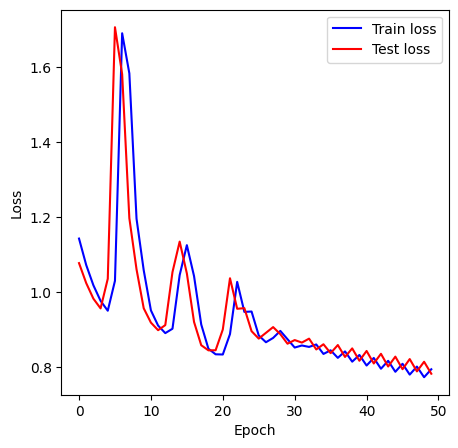

In [62]:
with torch.inference_mode():
    plt.figure(figsize=(5,5))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(epoch_values, train_loss_values, c='b', label='Train loss')
    plt.plot(epoch_values, test_loss_values, c='r', label='Test loss')
    plt.legend()

## Make Prediction

In [63]:
torch.manual_seed(42)
def make_prediction(model :nn.Module,
                    data :torch.Tensor):
    with torch.inference_mode():
        logits = model(data)
        pred = torch.softmax(logits, dim=1).argmax(dim=1)
        return pred

In [64]:
test_pred = make_prediction(model,
                            test_data.data.unsqueeze(1).type(torch.float))

test_pred == test_data.targets

tensor([ True,  True,  True,  ...,  True, False, False])

## Plot confusion matrix

In [65]:
confusion_matrix = ConfusionMatrix(task='multiclass',
                                   num_classes=len(test_data.classes))
confusion_matrix_tensor = confusion_matrix(preds=test_pred,
                                           target=test_data.targets)
confusion_matrix_tensor

tensor([[751,  10,   9, 111,  73,   0,  12,   0,  32,   2],
        [  3, 715,   5, 212,  63,   0,   0,   0,   2,   0],
        [  7,   1, 141,   8, 791,   0,   6,   0,  45,   1],
        [ 20,   9,   2, 771, 192,   0,   2,   0,   3,   1],
        [  0,   4,  15,  27, 941,   0,   0,   0,  12,   1],
        [  1,   0,   0,   3,   1,   1,   0, 123, 215, 656],
        [197,   4,  31,  61, 641,   0,   8,   0,  58,   0],
        [  0,   0,   0,   0,   0,   0,   0, 598,  79, 323],
        [  1,   2,   9,  16,  23,   0,   0,   1, 939,   9],
        [  0,   0,   0,   2,   0,   0,   0,   2,   2, 994]])

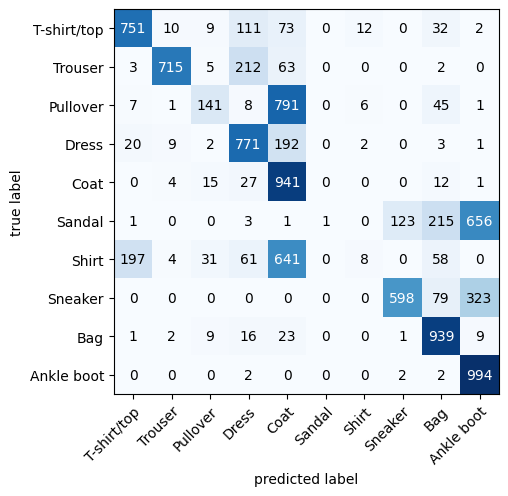

In [66]:
figure, axis = plot_confusion_matrix(
    confusion_matrix_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(5,5)
)

## Save model

In [ ]:
model_path = Path('models')
model_path.mkdir(parents=True,
                 exist_ok=True)
torch.save(obj=model,
           f='/Users/navalmor/Desktop/PyTorch_Learning/computer vision/models/FashionMNISTModel.pt')